In [1]:
import torch
import numpy as np
import math
from scipy.linalg import null_space
from numpy.linalg import svd
import matplotlib.pyplot as plt

def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

In [2]:
torch.device('cuda')
class admm(object):
    def __init__(self, C, A, b):
        self.C = C
        self.A = A
        self.b = b
        val = np.linalg.lstsq(self.A.numpy(), self.b.numpy())
        self.x0 = torch.from_numpy(val[0])
        self.Q = torch.from_numpy(null_space(self.A.numpy()))
        self.x = self.x0
        self.z = self.x
        self.mu = torch.zeros(self.z.size(), dtype=torch.double)
        self.omega = torch.zeros(self.z.size(), dtype=torch.double)
        self.rho = 1
        self.alpha = 1
        
    def h(self, z):
        if torch.min(z) < 0:
            to = [abs(torch.max(z))] * z.shape[0]
            val = torch.DoubleTensor(to).view(z.shape[0], z.shape[1])
            return val
        else: 
            return torch.zeros(z.shape, dtype=z.dtype)
        
    def iterate(self):
        val1 = torch.matmul(self.Q.t(), self.Q).inverse()
        val2 = torch.matmul(self.Q.t(), self.z - self.x0 - self.mu)
        val3 = 1/self.rho * torch.matmul(self.Q.t(), self.C)
        self.omega = torch.matmul(val1, val2 - val3)
        self.z = self.h(torch.matmul(self.Q, self.omega) + self.x0 + self.mu)
        self.mu = self.mu + torch.matmul(self.Q, self.omega) - self.z + self.x0
        
    def currentVal(self):
        val = torch.matmul(self.C.t(), self.x0 + torch.matmul(self.Q, self.omega))
        return val

In [3]:
M = 10
N = 100
A = torch.randn(M, N, dtype=torch.double)

C = torch.randn(N, 1, dtype=torch.double)
b = torch.randn(M, 1, dtype=torch.double)
opt = admm(C,A,b)

/anaconda2/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


In [4]:
b = []
for i in range(10):
    opt.iterate()
    b.append(opt.currentVal()[0][0].item())

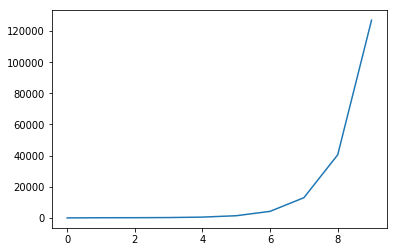

In [5]:
plt.plot(b)

In [259]:
print(b)

[-6.556248252087945e+40, -1.6706326063076113e+41, -4.257028101962598e+41, -1.0847560494436159e+42, -2.7641247805294565e+42, -7.043413868266454e+42, -1.7947698768571905e+43, -4.573348905971394e+43, -1.165359441644668e+44, -2.969514585815135e+44]
